   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 18.2 MB/s eta 0:00:00a 0:00:01


/var/folders/04/4ttssdxj3830bq6yhrshz1p80000gn/T/ipykernel_61585/2749624881.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range(start='2001-01', end='2023-12', freq='M')


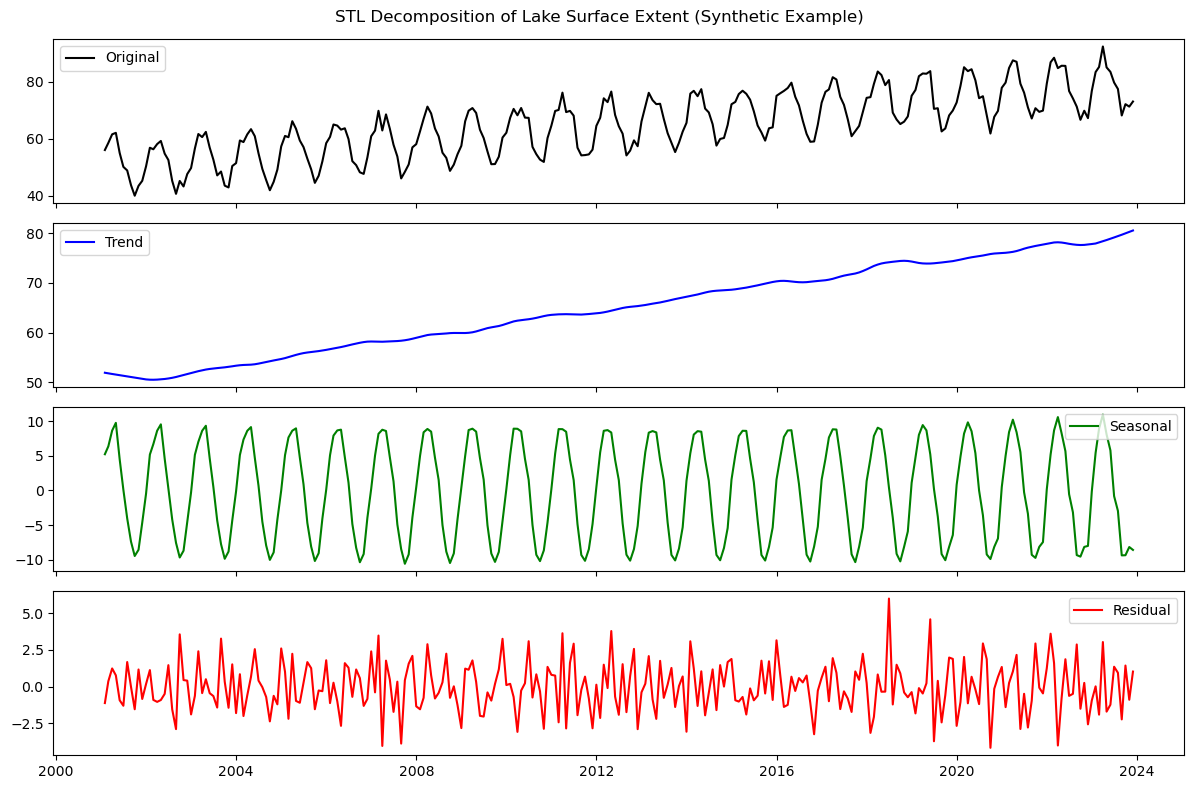

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# 1. Create synthetic monthly lake surface extent data (2001–2023)
np.random.seed(42)
months = pd.date_range(start='2001-01', end='2023-12', freq='M')
n = len(months)

# Simulate a seasonal signal (e.g., peak in July, trough in January)
seasonal = 10 * np.sin(2 * np.pi * months.month / 12)

# Simulate a long-term trend (e.g., slight increase per year)
trend = np.linspace(50, 80, n)

# Simulate random noise (e.g., interannual variability)
noise = np.random.normal(scale=2, size=n)

# Combine all components
surface_extent = trend + seasonal + noise

# Put in pandas Series
lake_series = pd.Series(surface_extent, index=months)

# 2. Apply STL decomposition
stl = STL(lake_series, seasonal=13)  # seasonal=13 assumes monthly seasonality
result = stl.fit()

# 3. Plot the decomposition
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
axs[0].plot(lake_series, label='Original', color='black')
axs[0].legend()
axs[1].plot(result.trend, label='Trend', color='blue')
axs[1].legend()
axs[2].plot(result.seasonal, label='Seasonal', color='green')
axs[2].legend()
axs[3].plot(result.resid, label='Residual', color='red')
axs[3].legend()
plt.suptitle('STL Decomposition of Lake Surface Extent (Synthetic Example)')
plt.tight_layout()
plt.show()

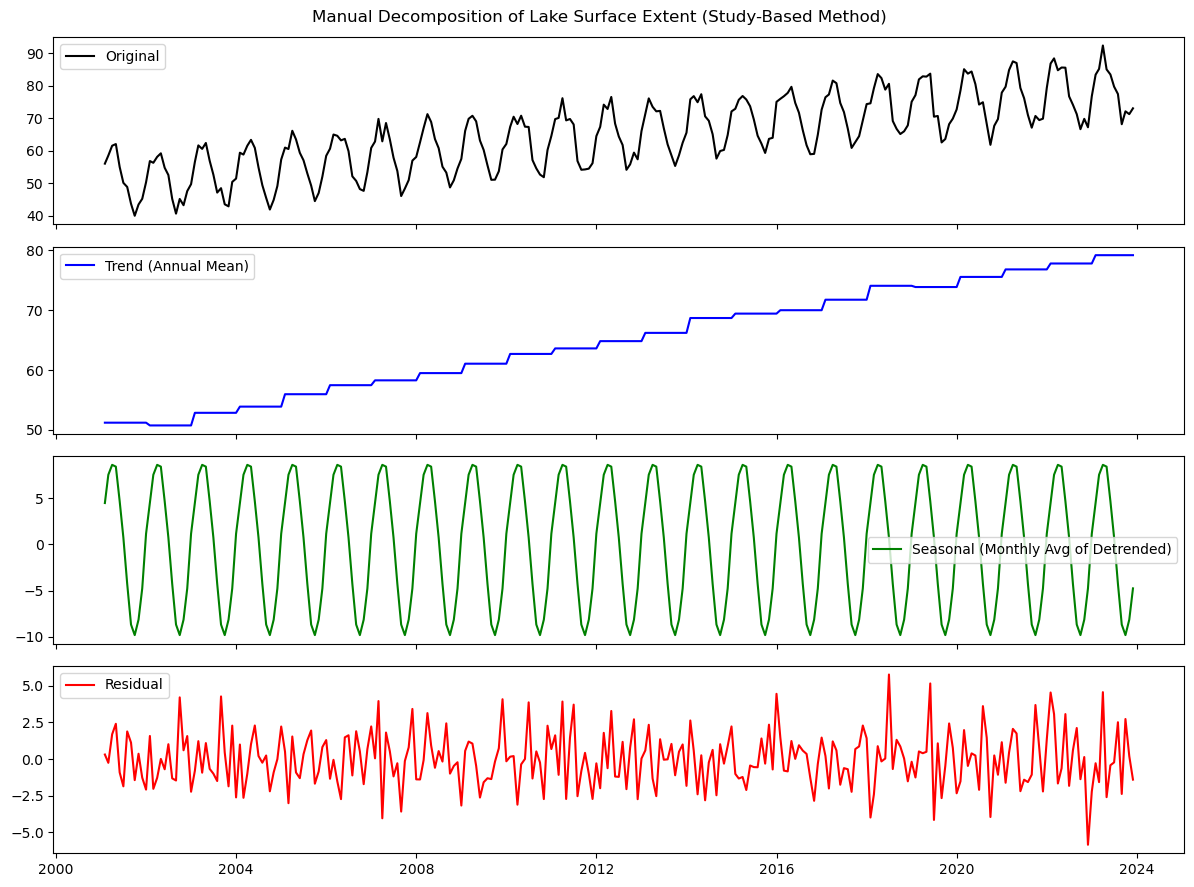

In [5]:
# Store in DataFrame
df = pd.DataFrame({'date': months, 'extent': surface_extent})
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# 2. Calculate long-term trend via annual means
annual_mean = df.groupby('year')['extent'].mean().rename('annual_mean')
df = df.merge(annual_mean, on='year')

# 3. Detrend the series by subtracting annual means (removes long-term trend)
df['detrended'] = df['extent'] - df['annual_mean']

# 4. Estimate seasonality by averaging the detrended series per month
monthly_seasonality = df.groupby('month')['detrended'].mean().rename('monthly_avg_seasonality')
df = df.merge(monthly_seasonality, on='month')

# 5. Remove seasonality to get residuals
df['residual'] = df['detrended'] - df['monthly_avg_seasonality']

# 6. Reconstruct components
df['trend_component'] = df['annual_mean']
df['seasonal_component'] = df['monthly_avg_seasonality']
df['reconstructed'] = df['trend_component'] + df['seasonal_component']

# 7. Plot each component
fig, axs = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
axs[0].plot(df['date'], df['extent'], label='Original', color='black')
axs[0].legend()
axs[1].plot(df['date'], df['trend_component'], label='Trend (Annual Mean)', color='blue')
axs[1].legend()
axs[2].plot(df['date'], df['seasonal_component'], label='Seasonal (Monthly Avg of Detrended)', color='green')
axs[2].legend()
axs[3].plot(df['date'], df['residual'], label='Residual', color='red')
axs[3].legend()
plt.suptitle('Manual Decomposition of Lake Surface Extent (Study-Based Method)')
plt.tight_layout()
plt.show()